# Image contrast simulation with brainweb data
This notebook demonstrates some simple contrast simulation with brainweb data

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
plt.style.use('dark_background')
brainweb_folder = 'brainweb_data'

In [81]:
def get_tissue_data(tissue):
    T1csf = 3.000
    T1wm = 0.700
    T1gm = 1.000
    T1ves = 1.000
    PDcsf = 1
    PDwm = 0.7
    PDgm = 0.8
    PDves = 1
    if tissue == 'csf':
        return T1csf, PDcsf
    elif tissue == 'gry':
        return T1gm, PDgm
    elif tissue == 'wht':
        return T1wm, PDwm
    elif tissue == 'ves':
        return T1ves, PDves
    else:
        return None, None

def spgr_sim(PD, T1, fa, TR):
    E1 = np.exp(-TR/T1)
    M = np.sin(fa)*PD * (1.0-E1) / (1.0-np.cos(fa)*E1)
    return M

def IR_sim(PD, T1, fa, TI):
    return PD * np.sin(fa) * ( 1-2*np.exp(-1.0*TI/T1))



In [91]:
brain = {}
tissues = ['wht', 'gry', 'csf', 'ves']
for tis in tissues:
    brain[tis] = np.array(nib.load(f'{brainweb_folder}/subject04_{tis}.nii.gz').get_fdata(), dtype=np.double) / 4095

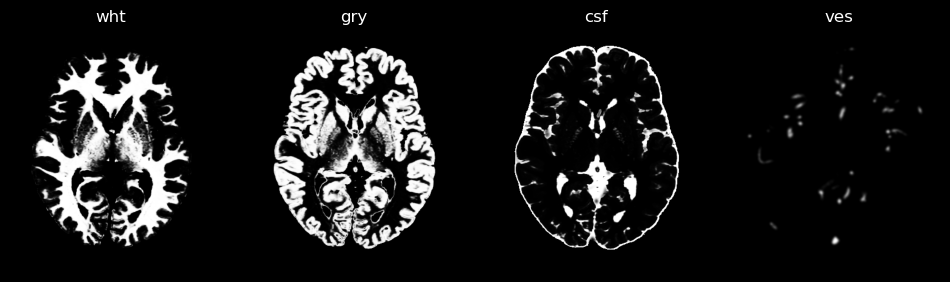

In [92]:
fig = plt.figure(figsize=(12,4))
for i, tis in enumerate(tissues):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(np.rot90(brain[tis][:,:,150]), cmap='gray')
    ax.set_title(tis)
    ax.axis('off')

In [76]:
def make_spgr_brain(TR, fa):
    nx, ny, nz = brain['wht'].shape
    iz = 150
    s = np.s_[:,:,iz]
    spgr_brain = np.zeros_like(brain['wht'][s])
    mask = np.zeros_like(brain['wht'][s])
    for tis in tissues:
        T1tis, PDtis = get_tissue_data(tis)
        data = brain[tis][s]
        mask[:] = 0
        mask[data>0] = 1
        T1map = mask * T1tis
        PDmap = data * PDtis
        spgr_brain += spgr_sim(PDmap, T1map, fa, TR)

    return spgr_brain

def make_ir_brain(TI, fa):
    nx, ny, nz = brain['wht'].shape
    iz = 150
    s = np.s_[:,:,iz]
    spgr_brain = np.zeros_like(brain['wht'][s])
    mask = np.zeros_like(brain['wht'][s])
    for tis in tissues:
        T1tis, PDtis = get_tissue_data(tis)
        data = brain[tis][s]
        mask[:] = 0
        mask[data>0] = 1
        T1map = mask * T1tis
        PDmap = data * PDtis
        spgr_brain += IR_sim(PDmap, T1map, fa, TI)

    return spgr_brain
    


/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_9214/3327822023.py:22: RuntimeWarning: divide by zero encountered in true_divide
  E1 = np.exp(-TR/T1)


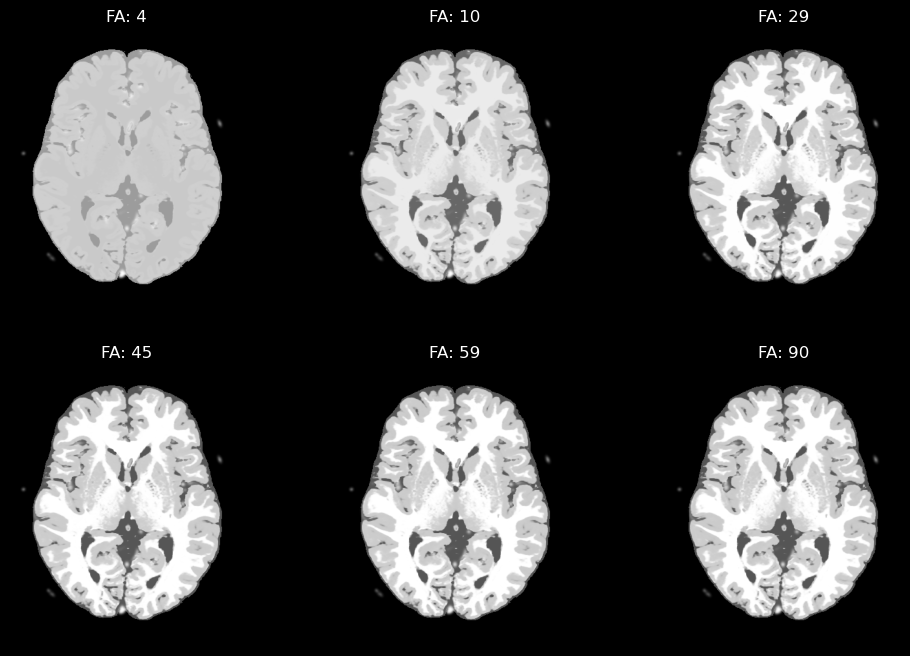

In [75]:
TR = 5E-3
fa = np.deg2rad([4,10,30,45,60,90])
fig = plt.figure(figsize=(12,8))
for i,a in enumerate(fa):
    fig.add_subplot(2,3,i+1)
    im = make_spgr_brain(TR, a)
    plt.imshow(np.rot90(im), cmap='gray'); plt.axis('off')
    plt.title(f'FA: {int(np.rad2deg(a))}')

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_9214/1278174487.py:27: RuntimeWarning: divide by zero encountered in true_divide
  return PD * np.sin(fa) * ( 1-2*np.exp(-1.0*TI/T1))


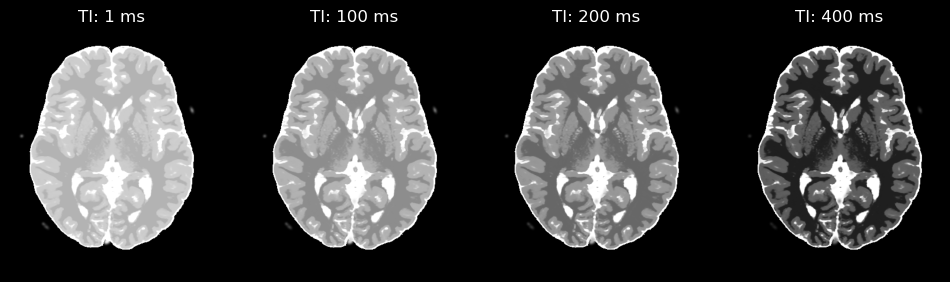

In [89]:
fa = np.pi/2
TI = np.array([0.001, 0.1, 0.2, 0.4])
fig = plt.figure(figsize=(12,4))
for i,t in enumerate(TI):
    fig.add_subplot(1,4,i+1)
    im = make_ir_brain(t, a)
    plt.imshow(np.rot90(np.abs(im)), cmap='gray', vmin=None, vmax=None); plt.axis('off')
    plt.title(f'TI: {t*1000:.0f} ms')